In [1]:
# Import libraries

#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals


#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#export the data

In [3]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Normalize the values

In [4]:


#@title Convert raw values to their Z-scores 

# Calculate the Z-scores of each column in the training set:
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Calculate the Z-scores of each column in the test set.
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

print("Normalized the values.")

Normalized the values.


# creating cross feature from longitude and latitude 

In [8]:
# creating cross feature from longitude and latitude 

# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# We scaled all the columns, including latitude and longitude, into their
# Z scores. So, instead of picking a resolution in degrees, we're going
# to use resolution_in_Zs.  A resolution_in_Zs of 1 corresponds to 
# a full standard deviation. 
resolution_in_Zs = 0.3  # 3/10 of a standard deviation.

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), 
                                     int(max(train_df_norm['latitude'])), 
                                     resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])), 
                                      int(max(train_df_norm['longitude'])), 
                                      resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)

# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)  

# Represent median_income as a floating-point value.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Represent population as a floating-point value.
population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# Define the plotting function.

In [9]:

def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


Create linear regression model

In [10]:
#@title Define functions to create and train a linear regression model
def create_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model           


def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["mean_squared_error"]

  return epochs, rmse   

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


Run the model with set hyperparameters

Epoch 1/15
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 0s 2ms/step - loss: 0.7948 - mean_squared_error: 0.7948
Epoch 2/15
17/17 [==============================] - 0s 2ms/step - loss: 0.5514 - mean_squared_error: 0.5514
Epoch 3/15
17/17 [==============================] - 0s 2ms/step - loss: 0.4389 - mean_squared_error: 0.4389
Epoch 4/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3863 - mean_squared_error: 0.3863
Epoch 5/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3682 - mean_squared_error: 0.3682
Epoch 6/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3633 - mean_squared_error: 0.3633
Epoch 7/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3610 - mean_squared_error: 0.3610
Epoch 8/15
17/17 [==============================] - 0s 2ms/step - loss: 0.3603 - mean_squared_error: 0.3603
Epoch 9/15
17/17 [========

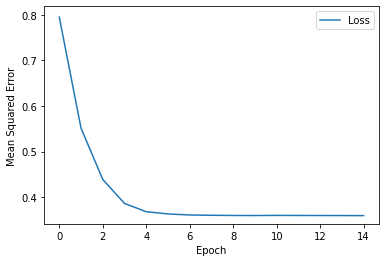


 Evaluate the linear regression model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 3ms/step - loss: 0.3949 - mean_squared_error: 0.3949


[0.3949344754219055, 0.3949344754219055]

In [11]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

# lets create deep learning neural network with additional layers


#lets define the create model function again

In [13]:
def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with 20 nodes.   
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  # Define the second hidden layer with 12 nodes. 
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  name='Hidden2'))
  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

# Define the training function

In [14]:
def train_model(model, dataset, epochs, label_name,
                batch_size=None):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse

# call the train function

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
17/17 [==============================] - 0s 3ms/step - loss: 0.6130 - mean_squared_error: 0.6130
Epoch 2/20
17/17 [==============================] - 0s 2ms/step - loss: 0.3737 - mean_squared_error: 0.3737
Epoch 3/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3482 - mean_squared_error: 0.3482
Epoch 4/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3408 - mean_squared_error: 0.3408
Epoch 5/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3367 - mean_squared_error: 0.3367
Epoch 6/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3352 - mean_squared_error: 0.3352
Epoch 7/20
17/17 [==============================] - 0s 3ms/step - loss: 0.3332 - mean_squared_error: 0.3332
Epoch 8/20
17/17 [==============================] - 0s 2ms/step - loss: 0.3311 - mean_squared_error: 0.3311
Epoch 9/20
17/17 [========

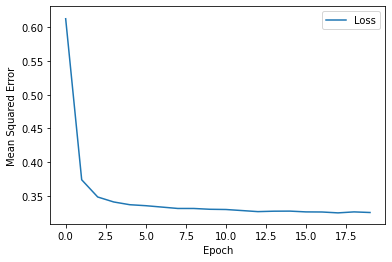


 Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
3/3 [==============================] - 0s 3ms/step - loss: 0.3662 - mean_squared_error: 0.3662


[0.36616572737693787, 0.36616572737693787]

In [15]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined by the feature_layer.
epochs, mse = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)